In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import osmnx as ox
import json
from shapely.geometry import shape, GeometryCollection, Polygon, Point

Matplotlib is building the font cache; this may take a moment.


### 04a-gsod

**Summary:** an exploration on using NOAA's GSOD (Global Summary of the Day) as a historical weather data source

**Before exploring:**
 - Download NOAA data through AWS.
 - Will come out as a set of CSV files, each CSV file has a numerical ID representing a station somewhere in the world. 
 - Inside the CSV, there will be an entry per day with weather data. 

**Challenge:** which stations are in Uttarakhand? Are they collecting data in 2021?
 - Download [.txt file](https://www.ncei.noaa.gov/pub/data/noaa/isd-history.txt) with all station names, locations, and start & end collection periods.
 - File is named `isd-history.txt`

`isd-history.txt` is a strange .txt file since its README is included in the file and it is not delimited in a nice way, so the following cell was run to process the data into a nice .csv, `isd-history.csv`. Since that .csv already exists, **you don't need to run this cell**.

In [65]:
df = pd.read_csv('isd-history.txt', header = 17)
cols = df.columns.str.split().values.tolist()[0] #establish individual columns

data = pd.DataFrame(columns=cols)

#manually add data to a dataframe
for index, row in df.iterrows():
    string = row[0]
    data.loc[index, cols[0]] = string[0:5]
    data.loc[index, cols[1]] = string[7:11]
    data.loc[index, cols[2]] = string[13:42]
    data.loc[index, cols[4]] = string[43:45]
    data.loc[index, cols[5]] = string[48:50]
    data.loc[index, cols[6]] = string[51:55]
    data.loc[index, cols[7]] = string[57:64]
    data.loc[index, cols[8]] = string[65:73]
    data.loc[index, cols[9]] = string[74:81] 
    data.loc[index, cols[10]] = string[82:90]
    data.loc[index, cols[11]] = string[91:99]
data.to_csv('isd-history.csv')

data = pd.read_csv('isd-history.csv')

data.drop(['Unnamed: 0'],axis=1)

#change latitude, longitude, and elevation to strings. manually handle empty values
for index, row in data.iterrows():
    try:
        data.loc[index, 'LAT'] = float(row['LAT'])
        data.loc[index, 'LON'] = float(row['LON'])
        data.loc[index, 'ELEV(M)'] = float(row['ELEV(M)'])
    except ValueError:
        data.loc[index, 'LAT'] = np.nan
        data.loc[index, 'LON'] = np.nan
    try:
        data.loc[index, 'ELEV(M)'] = float(row['ELEV(M)'])
    except ValueError:
        data.loc[index, 'ELEV(M)'] = np.nan

data.to_csv('isd-history.csv') #save it

Then, convert to geopandas and narrow search to all stations in India.

In [ ]:
data = pd.read_csv('isd-history.csv')
india_stations = data.loc[(data['CTRY'] == 'IN')]
gdf = gpd.GeoDataFrame(
    india_stations, geometry=gpd.points_from_xy(india_stations.LON, india_stations.LAT))

Download Uttarakhand's geographic boundaries from Open Street Maps.

In [ ]:
place_name = 'Uttarakhand, India'
place = ox.geocode_to_gdf(place_name)

Using [code template](https://stackoverflow.com/questions/63369715/filter-a-geopandas-dataframe-within-a-polygon-and-remove-from-the-dataframe-the), filter geodataframe to only include stations in Uttarakhand.

<ipython-input-238-6203ba7218c4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['withinQ'] = ""
<ipython-input-238-6203ba7218c4>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['withinQ'] = withinQlist


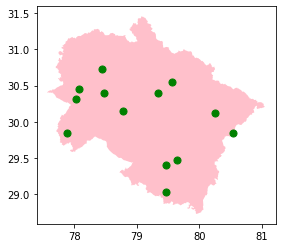

In [238]:
df = india_stations
# add new column to df
df['withinQ'] = ""

withinQlist = []
for lon,lat in zip(df.LON, df.LAT):
    pt = Point(lon, lat)
    withinQ = pt.within(place['geometry'].values[0])
    #print( withinQ )
    withinQlist.append(withinQ)

# update values in the that column, values: True/False
df['withinQ'] = withinQlist

# select points within ecuador, assign to `result_df` dataframe
result_df = df[df.withinQ==True]
# select points outside ecuador, assign to `xresult_df` dataframe
xresult_df = df[df.withinQ==False]

# for checking/visualization, create a plot of relevant geometries
ax1 = place.plot(color='pink')
ax1.scatter(result_df.LON, result_df.LAT, s=50, color='green')
#ax1.scatter(xresult_df.Longitude, xresult_df.Latitude, s=30, color='red')

Filter geodataframe to only include stations in Uttarakhand, in the timeframe that we want (in 2021). We'll see that only5 stations match this criteria, which is not helpful for this analysis.

In [262]:
df.loc[(df['withinQ'] == True) & (df['END'] > 20210000) ]

,Unnamed: 0,Unnamed: 0.1,USAF,WBAN,STATION,NAME,CTRY,ST,CALL,LAT,LON,ELEV(M),BEGIN,END,geometry,withinQ
9659,9659,9659,42111,9999,DEHRADUN,NaN,IN,,,30.317,78.033,682,19440101,20210803,POINT (78.03300 30.31700),True
9661,9661,9661,42114,9999,TEHRI,NaN,IN,,,30.4,78.483,770,19981224,20210803,POINT (78.48300 30.40000),True
9664,9664,9664,42121,9999,MUNSYARI,NaN,IN,,,30.117,80.25,3414,20011024,20210420,POINT (80.25000 30.11700),True
9674,9674,9674,42147,9999,MUKTESHWAR KUMAON,NaN,IN,,,29.467,79.65,2311,19440101,20210803,POINT (79.65000 29.46700),True
9675,9675,9675,42148,9999,PANTNAGAR,NaN,IN,,,29.033,79.467,233,20070520,20210803,POINT (79.46700 29.03300),True


**Appendix**

Potentially helpful links:
 - [download txt from chrome](https://apple.stackexchange.com/questions/42187/how-can-i-download-plain-txt-files-in-safari-chrome)
 - [how to load txt file](https://stackoverflow.com/questions/21546739/load-data-from-txt-with-pandas)
 - [`pd.read_csv` docs](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html)
 - [np array object to list](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.tolist.html)
 - [iterrows example](https://stackoverflow.com/questions/16476924/how-to-iterate-over-rows-in-a-dataframe-in-pandas)
 - [export pandas to csv](https://datatofish.com/export-dataframe-to-csv/)
 - [drop column](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html)
 - [try except statements](https://docs.python.org/3/tutorial/errors.html)
 - [geopandas from latitude and longitude](https://geopandas.org/gallery/create_geopandas_from_pandas.html)